In [1]:
import numpy as np
from scipy.stats import beta as beta_dist
from scipy.optimize import linprog

class FixedPlanClairvoyantOracle:
    """
    Clairvoyant that plans once at t=0 via a single LP over the whole horizon
    and then follows that plan regardless of realizations.

    LP:
      Variables x_{t,k} = prob of playing arm k at round t
      Maximize   sum_{t,k} (price_k * s_{t,k}) * x_{t,k}
      s.t.       sum_k x_{t,k} = 1       for each t
                 sum_{t,k} s_{t,k} x_{t,k} <= B
                 x_{t,k} >= 0
      where s_{t,k} = P[v_t >= price_k] = 1 - BetaCDF(price_k; a_t, b_t)

    Behavior:
      - Precompute the full schedule x_{t,·} once.
      - At round t, sample an arm from x_{t,·} (or argmax if deterministic=True).
      - Budget is decremented only on realized sales; the plan does not change.
    """

    def __init__(self, arm_values, T, B, params, rng=None, deterministic=False):
        self.prices = np.asarray(arm_values, dtype=float)
        self.K = len(self.prices)
        self.T = int(T)
        self.B0 = int(B)
        self.params = list(params)
        self.rng = np.random.default_rng(rng)
        self.deterministic = bool(deterministic)

        self.t = 0
        self.remaining_budget = int(B)
        self.total_reward = 0.0

        # Precompute success probabilities S[t,k]
        a = np.fromiter((p[0] for p in self.params), dtype=float, count=self.T)
        b = np.fromiter((p[1] for p in self.params), dtype=float, count=self.T)
        P = self.prices[None, :]  # (1,K)
        self.S = 1.0 - beta_dist.cdf(P, a[:, None], b[:, None])  # (T,K)

        # Solve the LP once to get the plan X of shape (T,K)
        self.X = self._solve_plan()
        # Optional: precompute deterministic choices
        if self.deterministic:
            self.plan_arms = np.argmax(self.X, axis=1)
        else:
            self.plan_arms = None

    # ---------- helpers ----------
    @staticmethod
    def _project_to_simplex_rowwise(M):
        """Project each row of M onto the probability simplex."""
        M = np.asarray(M, dtype=float)
        T, K = M.shape
        out = np.empty_like(M)
        for i in range(T):
            v = M[i]
            if not np.isfinite(v).all():
                out[i] = np.full(K, 1.0 / K)
                continue
            u = np.sort(v)[::-1]
            cssv = np.cumsum(u)
            rho_idx = np.nonzero(u * (np.arange(1, K+1)) > (cssv - 1.0))[0]
            if len(rho_idx) == 0:
                out[i] = np.full(K, 1.0 / K)
                continue
            rho = rho_idx[-1]
            theta = (cssv[rho] - 1.0) / (rho + 1.0)
            w = np.maximum(v - theta, 0.0)
            s = w.sum()
            out[i] = w / s if s > 0 else np.full(K, 1.0 / K)
        return out

    def _solve_plan(self):
        T, K = self.T, self.K
        S = self.S
        prices = self.prices

        # Flatten indices: var index for (t,k) is t*K + k
        N = T * K

        # Objective: maximize sum_t,k price_k * S[t,k] * x_{t,k}
        # linprog minimizes -> use negative
        c = -(S * prices[None, :]).reshape(-1)

        # Equality constraints: for each t, sum_k x_{t,k} = 1
        A_eq = np.zeros((T, N), dtype=float)
        for t in range(T):
            A_eq[t, t*K:(t+1)*K] = 1.0
        b_eq = np.ones(T, dtype=float)

        # Budget constraint: sum_{t,k} S[t,k] * x_{t,k} <= B
        A_ub = S.reshape(1, -1)
        b_ub = np.array([float(self.B0)], dtype=float)

        bounds = [(0.0, 1.0)] * N

        res = linprog(c, A_ub=A_ub, b_ub=b_ub,
                      A_eq=A_eq, b_eq=b_eq,
                      bounds=bounds, method="highs")

        if not res.success or res.x is None:
            # Fallback: if LP fails, choose per-round the arm maximizing price*success
            X = np.zeros((T, K), dtype=float)
            best = np.argmax(S * prices[None, :], axis=1)
            X[np.arange(T), best] = 1.0
            return X

        # Reshape to (T,K) and clean numeric noise
        X = res.x.reshape(T, K)
        X = np.maximum(X, 0.0)
        X = self._project_to_simplex_rowwise(X)
        return X

    # ---------- public API ----------
    def choose_arm(self):
        if self.remaining_budget <= 0 or self.t >= self.T:
            return None
        if self.deterministic:
            a = int(self.plan_arms[self.t])
        else:
            a = int(self.rng.choice(self.K, p=self.X[self.t]))
        return a

    def update(self, chosen_arm, realized_reward):
        if chosen_arm is None:
            self.t += 1
            return
        sale = (realized_reward > 0)
        if sale and self.remaining_budget > 0:
            self.remaining_budget -= 1
        self.total_reward += float(realized_reward)
        self.t += 1

    def state(self):
        return {
            "t": self.t,
            "remaining_budget": self.remaining_budget,
            "total_reward": self.total_reward,
        }


In [2]:
import numpy as np
from scipy.optimize import linprog

# ------------------------
# Budgeted Learning Agent 
# ------------------------

class BudgetedUCBAgent:
    def __init__(self, arm_values, T, B, rng=None):
        self.arm_values = np.array(arm_values, dtype=float)
        self.K = len(self.arm_values)
        self.T = int(T)
        self.B = int(B)
        self.remaining_budget = int(B)

        self.counts = np.zeros(self.K, dtype=float)
        self.successes = np.zeros(self.K, dtype=float)
        self.total_rewards = np.zeros(self.K, dtype=float)

        self.t = 0
        self.rng = np.random.default_rng(rng)  # reproducible if you pass a seed

    def _project_to_simplex(self, v):
        """
        Euclidean projection onto the probability simplex:
          { x >= 0, sum x = 1 }.
        Robust against tiny negative entries / sums != 1 from LP solvers.
        """
        v = np.asarray(v, dtype=float)
        if not np.isfinite(v).all():
            return np.full_like(v, 1.0 / len(v))
        n = v.size
        u = np.sort(v)[::-1]
        cssv = np.cumsum(u)
        rho_idx = np.nonzero(u * np.arange(1, n + 1) > (cssv - 1.0))[0]
        if len(rho_idx) == 0:
            return np.full_like(v, 1.0 / n)
        rho = rho_idx[-1]
        theta = (cssv[rho] - 1.0) / (rho + 1.0)
        w = np.maximum(v - theta, 0.0)
        s = w.sum()
        if s <= 0 or not np.isfinite(s):
            return np.full_like(v, 1.0 / n)
        return w / s

    def choose_arm(self):
        # If budget depleted or all rounds played, stop
        if self.remaining_budget <= 0 or self.t >= self.T:
            return None

        self.t += 1

        # Ensure each arm is pulled at least once
        for i in range(self.K):
            if self.counts[i] == 0:
                return i

        mean_reward = self.total_rewards / self.counts
        mean_success_prob = self.successes / self.counts
        confidence = np.sqrt(2.0 * np.log(self.T) / self.counts)

        ucb_reward = mean_reward + confidence
        lcb_cost = np.maximum(mean_success_prob - confidence, 1e-6)

        # Allowed expected budget per round
        rounds_left_including_now = max(1, self.T - self.t + 1)
        rho = self.remaining_budget / rounds_left_including_now

        # Linear program
        c = -ucb_reward
        A_ub = [lcb_cost]
        b_ub = [rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1.0]
        bounds = [(0.0, 1.0) for _ in range(self.K)]

        res = linprog(c, A_ub=A_ub, b_ub=b_ub,
                      A_eq=A_eq, b_eq=b_eq,
                      bounds=bounds, method='highs')

        if not res.success or res.x is None:
            # Fallback: choose arm with best reward-to-cost ratio
            ratios = ucb_reward / lcb_cost
            return int(np.argmax(ratios))

        # --- Numerical hygiene on the LP mixture ---
        gamma = self._project_to_simplex(res.x)

        # Final guard (very defensive): if anything is off, fallback
        if (gamma < 0).any() or not np.isfinite(gamma).all() or abs(gamma.sum() - 1.0) > 1e-6:
            ratios = ucb_reward / lcb_cost
            return int(np.argmax(ratios))

        return int(self.rng.choice(self.K, p=gamma))

    def update(self, arm_index, reward):
        self.counts[arm_index] += 1.0
        self.total_rewards[arm_index] += float(reward)

        if reward > 0 and self.remaining_budget > 0:
            self.successes[arm_index] += 1.0
            self.remaining_budget = max(0, self.remaining_budget - 1)

In [3]:
import numpy as np

class PrimalDualExp3PAgent:
    """
    Primal–dual pacing with EXP3.P as the primal regret minimizer.
    Sale-centric reward for the primal:
      - success: reward = max(price - λ, 0) ∈ [0,1]
      - failure: reward = 0
    Optional non-stationary helpers:
      - eta_mult: scale the canonical eta to react faster
      - forget_beta: exponential forgetting of weights each round
    API unchanged: choose_arm(), update(arm_index, reward).
    """

    def __init__(self, arm_values, T, B,
                 eta=None, gamma=None, alpha=None, dual_lr=None, rng=None,
                 eta_mult=1.0, forget_beta=0.0):
        self.prices = np.asarray(arm_values, dtype=float)
        self.K = len(self.prices)
        self.T = int(T)
        self.B0 = int(B)

        # Pacing: constant rho and cap per pseudocode
        self.rho = self.B0 / float(self.T)
        self.lambda_cap = 1.0 / max(self.rho, 1e-12)

        # EXP3.P canonical parameters (if not provided)
        if gamma is None:
            gamma = min(0.4, np.sqrt(self.K * np.log(max(2, self.K)) / max(1, self.T)))
        if eta is None:
            eta = gamma / (3.0 * max(1, self.K))
        if alpha is None:
            alpha = gamma / (3.0 * max(1, self.K))
        if dual_lr is None:
            dual_lr = eta  # per pacing pseudocode

        # Non-stationary knobs
        self.eta = float(eta) * float(eta_mult)   # <— faster adaptation if eta_mult>1
        self.gamma = float(gamma)
        self.alpha = float(alpha)
        self.dual_lr = float(dual_lr)
        self.forget_beta = float(forget_beta)     # 0 = off; e.g., 0.02 = gentle forgetting

        # State
        self.weights = np.ones(self.K, dtype=float)
        self.last_probs = np.full(self.K, 1.0 / self.K)
        self.last_arm = None

        self.lmbda = 0.0
        self.t = 0
        self.remaining_budget = int(B)
        self.total_reward = 0.0

        self.rng = np.random.default_rng(rng)

    # ---------- helpers ----------
    def _probs(self):
        w = self.weights
        w_sum = w.sum()
        if not np.isfinite(w_sum) or w_sum <= 0:
            w = np.ones_like(w); w_sum = w.sum()
        base = (1.0 - self.gamma) * (w / w_sum)
        mix  = self.gamma / self.K
        p = base + mix
        p = np.clip(p, 1e-12, 1.0)
        p /= p.sum()
        return p

    # ---------- public API ----------
    def choose_arm(self):
        if self.remaining_budget <= 0 or self.t >= self.T:
            return None
        p = self._probs()
        a = int(self.rng.choice(self.K, p=p))
        self.last_probs = p
        self.last_arm = a
        return a

    def update(self, arm_index, reward):
        if arm_index is None:
            return

        # Outcome & book-keeping
        sale = (reward > 0)
        cost = 1 if sale else 0
        self.total_reward += float(reward)

        # ---- Sale-centric reward for the primal (in [0,1]) ----
        if sale:
            bandit_reward = max(self.prices[arm_index] - self.lmbda, 0.0)
        else:
            bandit_reward = 0.0

        # ---- EXP3.P update (all weights) ----
        p = self.last_probs
        xhat = np.zeros(self.K, dtype=float)
        p_arm = float(p[arm_index])
        xhat[arm_index] = bandit_reward / max(p_arm, 1e-12)

        bias = self.alpha / (np.maximum(p, 1e-12) * np.sqrt(self.K * self.T))
        self.weights *= np.exp(self.eta * (xhat + bias))

        # Optional exponential forgetting (helps at regime switches)
        if self.forget_beta > 0.0:
            self.weights = self.weights ** (1.0 - self.forget_beta)

        # ---- Dual update (pacing) ----
        self.lmbda = float(np.clip(self.lmbda - self.dual_lr * (self.rho - cost),
                                   0.0, self.lambda_cap))

        # Budget & time
        if sale and self.remaining_budget > 0:
            self.remaining_budget -= 1
        self.t += 1

    # Inspectors
    def current_probs(self):
        return self._probs().copy()

    def state(self):
        return {
            "t": self.t,
            "remaining_budget": self.remaining_budget,
            "lambda": self.lmbda,
            "rho": self.rho,
            "probs": self._probs(),
            "weights": self.weights.copy(),
            "total_reward": self.total_reward,
        }


In [4]:
import numpy as np

class TrendFlipBetaEnvironment:
    """
    Beta environment with per-round mean drift and periodic trend flips.

    Mean evolves as:
      mu_{t+1} = mu_t + dir * u,   dir in {+1, -1}
      Flip dir every K rounds (i.e., at t = K, 2K, 3K, ...).
      Reflect mu at [mu_min, mu_max] bounds.

    Variance kept uniformly small via fixed concentration:
      c = 0.25 / v_target - 1   (so Var_t <= v_target for all t).
      a_t = mu_t * c,  b_t = (1 - mu_t) * c.

    Args:
      T         : horizon
      u         : per-round mean step (e.g., 0.01 or 0.02)
      K         : rounds per trend segment before flipping direction
      mu0       : start mean (default 0.2)
      v_target  : variance upper bound (e.g., 0.02 or 0.05)
      mu_bounds : (mu_min, mu_max) reflection bounds
      start_dir : +1 (ascending) or -1 (descending) initial direction
      seed      : RNG seed
    """
    def __init__(self, T, u, K, mu0=0.2, v_target=0.02,
                 mu_bounds=(0.05, 0.95), start_dir=+1, seed=None):
        self.T = int(T)
        self.u = float(u)
        self.K = int(K)
        self.mu0 = float(mu0)
        self.mu_min, self.mu_max = map(float, mu_bounds)
        self.dir0 = 1 if start_dir >= 0 else -1
        assert 0 < self.mu_min < self.mu_max < 1
        assert 0 < self.u < 1
        assert self.K >= 1

        # fixed concentration from target variance at mu=0.5
        self.v_target = float(v_target)
        assert 0.0 < self.v_target < 0.25
        self.c = 0.25 / self.v_target - 1.0

        self.rng = np.random.default_rng(seed)
        self.samples = []
        self.params = []   # list of (a_t, b_t)
        self.mu_series = []
        self._generate()

    def _reflect(self, mu, direction):
        # reflect at bounds if we crossed; return (mu, direction)
        if mu > self.mu_max:
            overshoot = mu - self.mu_max
            mu = self.mu_max - overshoot
            direction *= -1
        elif mu < self.mu_min:
            overshoot = self.mu_min - mu
            mu = self.mu_min + overshoot
            direction *= -1
        return mu, direction

    def _generate(self):
        mu = np.clip(self.mu0, self.mu_min, self.mu_max)
        direction = self.dir0
        for t in range(self.T):
            # record current mu
            self.mu_series.append(float(mu))
            # params for this round
            a = max(mu * self.c, 1e-9)
            b = max((1.0 - mu) * self.c, 1e-9)
            v = self.rng.beta(a, b)
            self.samples.append(float(v))
            self.params.append((float(a), float(b)))

            # step mean for next round
            if t < self.T - 1:
                # flip direction every K rounds (at t = K, 2K, ...)
                if (t + 1) % self.K == 0:
                    direction *= -1
                mu = mu + direction * self.u
                mu, direction = self._reflect(mu, direction)

    # Public API
    def get_all_samples(self):
        return np.array(self.samples, dtype=float), list(self.params)

    def get_mu_path(self):
        return np.array(self.mu_series, dtype=float)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def run_agents_on_trendflip_env_with_oracle(
    arm_values, T, B,
    # Environment params
    u=0.015, K=25, mu0=0.2, v_target=0.02, mu_bounds=(0.05,0.95), start_dir=+1,
    seed=None,
    # PD hyperparams
    exp3p_eta=None, exp3p_gamma=None, exp3p_dual_lr=None, alpha=None
):
    # --- Environment ---
    env = TrendFlipBetaEnvironment(
        T=T, u=u, K=K, mu0=mu0,
        v_target=v_target, mu_bounds=mu_bounds,
        start_dir=start_dir, seed=seed
    )
    valuations, params = env.get_all_samples()
    prices = np.asarray(arm_values, dtype=float)

    # --- Agents ---
    ucb = BudgetedUCBAgent(arm_values, T, B, rng=seed)
    pd  = PrimalDualExp3PAgent(
        arm_values, T, B,
        eta=exp3p_eta, gamma=exp3p_gamma, alpha=alpha,
        dual_lr=exp3p_dual_lr, rng=seed
    )
    orc = FixedPlanClairvoyantOracle(
    arm_values, T, B, params=params, rng=seed,
    deterministic=False  # or True if you prefer argmax per round 
    )

    # --- Tracking ---
    R_ucb = R_pd = R_orc = 0.0
    dep_ucb = dep_pd = dep_orc = None
    cum_ucb, cum_pd, cum_orc = [], [], []

    # --- Simulation ---
    for t in range(T):
        v = float(valuations[t])

        # UCB
        a_ucb = ucb.choose_arm()
        if a_ucb is not None:
            r = prices[a_ucb] if (v >= prices[a_ucb] and ucb.remaining_budget > 0) else 0.0
            ucb.update(a_ucb, r)
            R_ucb += r
            if ucb.remaining_budget <= 0 and dep_ucb is None:
                dep_ucb = t + 1
        cum_ucb.append(R_ucb)

        # Primal–Dual
        a_pd = pd.choose_arm()
        if a_pd is not None:
            r = prices[a_pd] if (v >= prices[a_pd] and pd.remaining_budget > 0) else 0.0
            pd.update(a_pd, r)
            R_pd += r
            if pd.remaining_budget <= 0 and dep_pd is None:
                dep_pd = t + 1
        cum_pd.append(R_pd)

        # Clairvoyant Oracle
        a_orc = orc.choose_arm()
        if a_orc is not None:
            r = prices[a_orc] if (v >= prices[a_orc] and orc.remaining_budget > 0) else 0.0
            orc.update(a_orc, r)
            R_orc += r
            if orc.remaining_budget <= 0 and dep_orc is None:
                dep_orc = t + 1
        cum_orc.append(R_orc)

        # Optional early stop if everyone is out of budget
        if (ucb.remaining_budget <= 0
            and pd.remaining_budget <= 0
            and orc.remaining_budget <= 0):
            break

    # --- Diagnostics / labels ---
    ratio_ucb = (R_ucb / R_orc) if R_orc > 0 else np.nan
    ratio_pd  = (R_pd  / R_orc) if R_orc > 0 else np.nan

    lbl_ucb = (
        f"UCB | Total={R_ucb:.2f} | "
        f"{'Depleted@'+str(dep_ucb) if dep_ucb else 'Budget left='+str(ucb.remaining_budget)} | "
        f"UCB/Oracle={ratio_ucb:.2f}"
    )
    lbl_pd = (
        f"Primal–Dual | Total={R_pd:.2f} | "
        f"{'Depleted@'+str(dep_pd) if dep_pd else 'Budget left='+str(pd.remaining_budget)} | "
        f"PD/Oracle={ratio_pd:.2f}"
    )
    lbl_orc = (
        f"Clairvoyant | Total={R_orc:.2f} | "
        f"{'Depleted@'+str(dep_orc) if dep_orc else 'Budget left='+str(orc.remaining_budget)}"
    )

    # --- Plot ---
    plt.figure(figsize=(11, 6))
    rounds = np.arange(1, len(cum_orc) + 1)

    plt.plot(rounds, cum_orc, lw=2.5, label=lbl_orc)
    plt.plot(rounds, cum_ucb, lw=2,   label=lbl_ucb)
    plt.plot(rounds, cum_pd,  lw=2,   label=lbl_pd)

    # mark trend flips
    for tflip in range(K, T, K):
        plt.axvline(tflip, ls='--', color='k', alpha=0.25)

    plt.xlabel("Round")
    plt.ylabel("Cumulative reward")
    plt.title(f"Cumulative Reward — UCB vs Primal–Dual vs Clairvoyant  (T={T}, B={B})")
    plt.legend(fontsize=9)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- Console summary ---
    print("=== Final Results (TrendFlip env, with Oracle) ===")
    print(lbl_orc)
    print(lbl_ucb)
    print(lbl_pd)

    return {
        "cum_ucb": np.array(cum_ucb),
        "cum_pd":  np.array(cum_pd),
        "cum_orc": np.array(cum_orc),
        "R_ucb": R_ucb, "R_pd": R_pd, "R_orc": R_orc,
        "dep_ucb": dep_ucb, "dep_pd": dep_pd, "dep_orc": dep_orc,
        "ratio_ucb": ratio_ucb, "ratio_pd": ratio_pd,
    }


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_trendflip_values(
    T,
    u=0.02,
    K=25,
    mu0=0.2,
    v_target=0.02,
    mu_bounds=(0.05, 0.95),
    start_dir=+1,
    seed=None
):
    """
    Generate and plot valuation samples from TrendFlipBetaEnvironment.
    
    Args:
      T         : number of rounds
      u         : mean step size per round
      K         : rounds before flipping trend
      mu0       : initial mean
      v_target  : target variance upper bound
      mu_bounds : (min, max) bounds for mean reflection
      start_dir : +1 (ascending) or -1 (descending) starting direction
      seed      : RNG seed
    """
    env = TrendFlipBetaEnvironment(
        T=T, u=u, K=K, mu0=mu0,
        v_target=v_target, mu_bounds=mu_bounds,
        start_dir=start_dir, seed=seed
    )
    values, _ = env.get_all_samples()
    mu_path   = env.get_mu_path()

    rounds = np.arange(1, T+1)

    plt.figure(figsize=(12,5))
    plt.plot(rounds, values, ".", alpha=0.5, label="Sampled valuations")
    plt.plot(rounds, mu_path, "-", color="red", lw=1, label="Mean trajectory")

    # mark trend flips
    for t in range(K, T, K):
        plt.axvline(t, ls="--", color="k", alpha=0.3)

    plt.xlabel("Round")
    plt.ylabel("Valuation")
    plt.title("TrendFlipBetaEnvironment: sampled values and mean trajectory")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


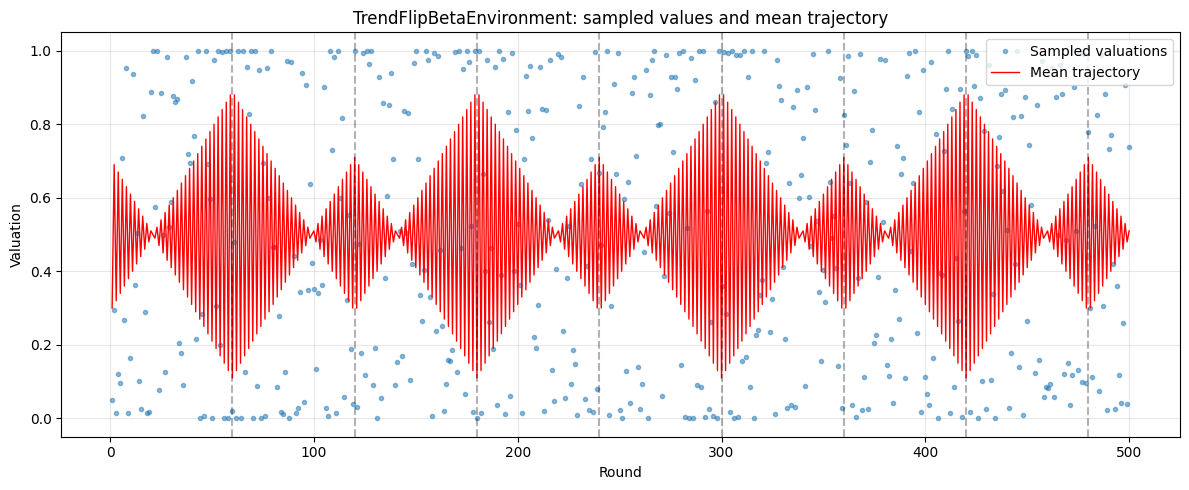

In [7]:
plot_trendflip_values(
    T=500,
    u=0.91,
    K=60,
    mu0=0.3,
    v_target=0.12,
)

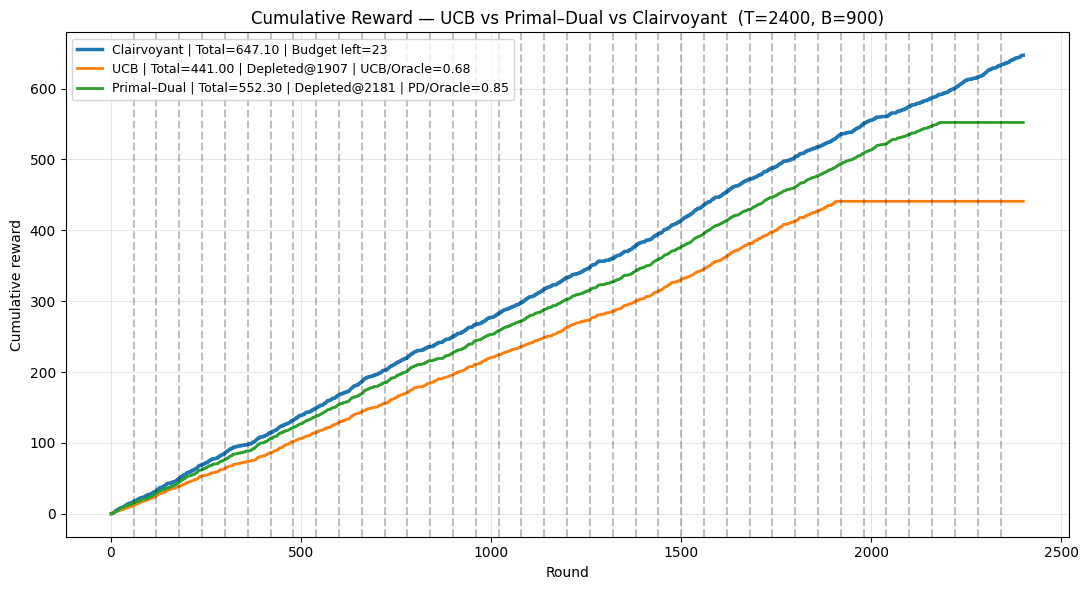

=== Final Results (TrendFlip env, with Oracle) ===
Clairvoyant | Total=647.10 | Budget left=23
UCB | Total=441.00 | Depleted@1907 | UCB/Oracle=0.68
Primal–Dual | Total=552.30 | Depleted@2181 | PD/Oracle=0.85


In [8]:
res = run_agents_on_trendflip_env_with_oracle(
    arm_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    T=2400,
    B=900,         # B/T = 0.375
    u=0.91,       # mean drift per round
    K=60,         # flip every 125 rounds
    mu0=0.3,
    v_target=0.12,
    # PD params (tune as you like)
    exp3p_gamma=None,
    exp3p_eta=0.2,        # canonical eta (gamma/(3K))
    exp3p_dual_lr=0.01,    # pacing step = eta
    alpha=None
)

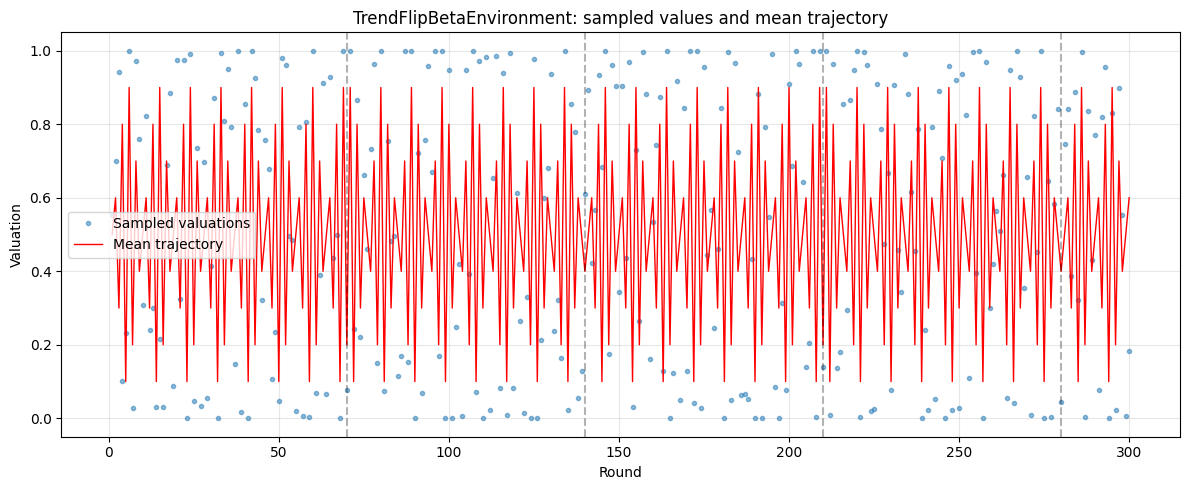

In [9]:
plot_trendflip_values(
    T=300,
    u=0.8,
    K=70,
    mu0=0.5,
    v_target=0.1,
)

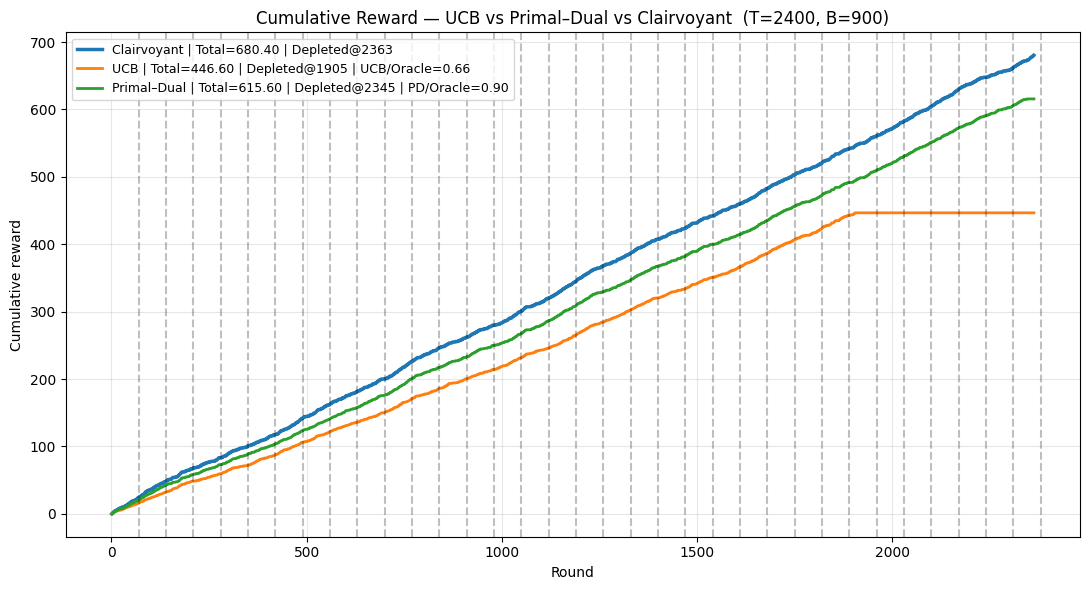

=== Final Results (TrendFlip env, with Oracle) ===
Clairvoyant | Total=680.40 | Depleted@2363
UCB | Total=446.60 | Depleted@1905 | UCB/Oracle=0.66
Primal–Dual | Total=615.60 | Depleted@2345 | PD/Oracle=0.90


In [10]:
res = run_agents_on_trendflip_env_with_oracle(
    arm_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    T=2400,
    B=900,         # B/T = 0.375
    u=0.8,       # mean drift per round
    K=70,         # flip every 125 rounds
    mu0=0.5,
    v_target=0.11,
    # PD params (tune as you like)
    exp3p_gamma=None,
    exp3p_eta=0.2,        # canonical eta (gamma/(3K))
    exp3p_dual_lr=0.01,    # pacing step = eta
    alpha=None
)

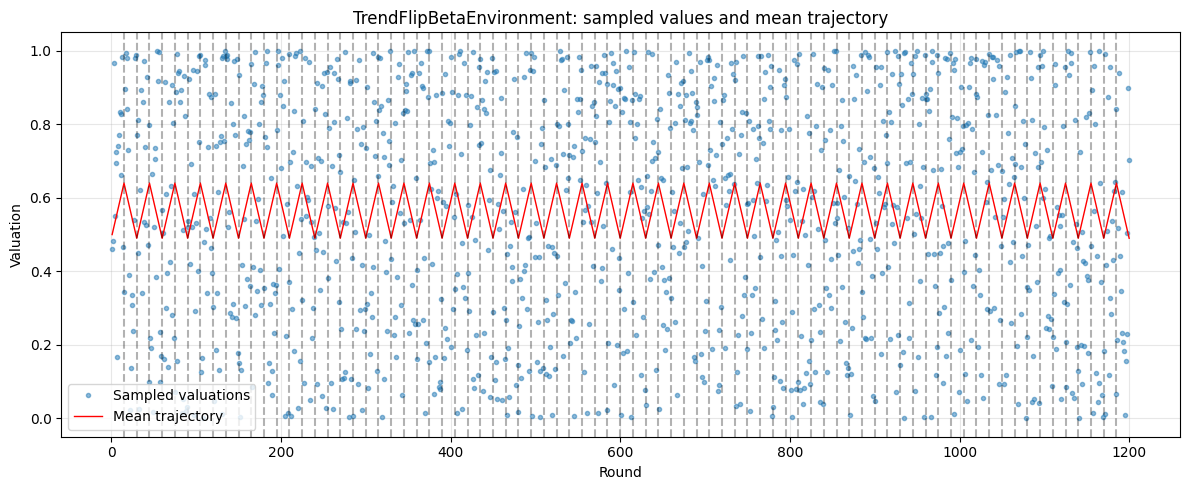

In [11]:
plot_trendflip_values(
    T=1200,
    u=0.01,
    K=15,
    mu0=0.5,
    v_target=0.1,
)

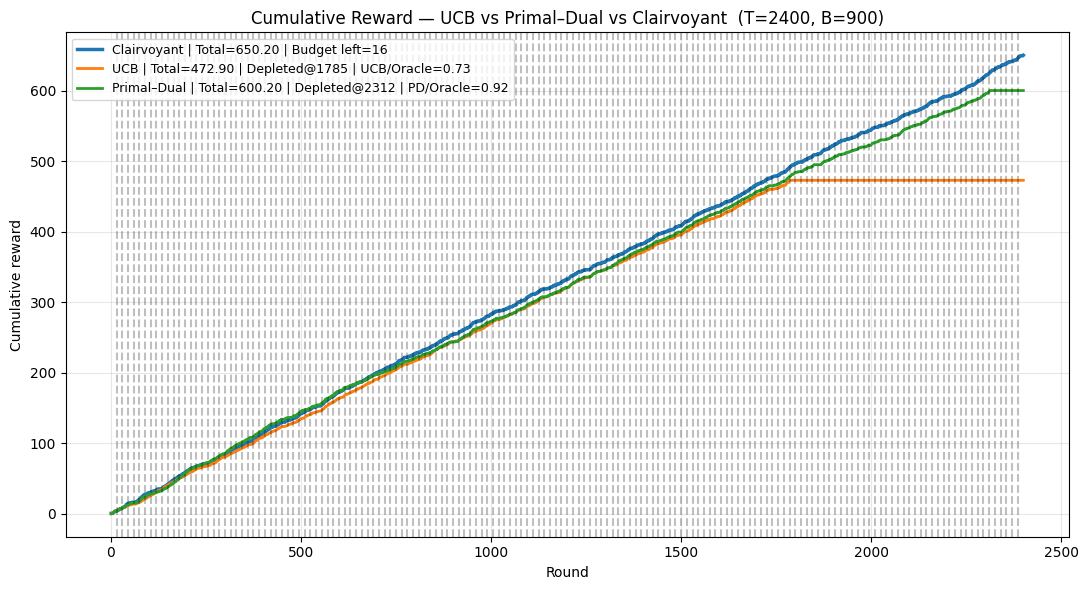

=== Final Results (TrendFlip env, with Oracle) ===
Clairvoyant | Total=650.20 | Budget left=16
UCB | Total=472.90 | Depleted@1785 | UCB/Oracle=0.73
Primal–Dual | Total=600.20 | Depleted@2312 | PD/Oracle=0.92


In [12]:
res = run_agents_on_trendflip_env_with_oracle(
    arm_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    T=2400,
    B=900,         # B/T = 0.375
    u=0.01,       # mean drift per round
    K=15,         # flip every 125 rounds
    mu0=0.5,
    v_target=0.1,
    # PD params (tune as you like)
    exp3p_gamma=None,
    exp3p_eta=0.2,        # canonical eta (gamma/(3K))
    exp3p_dual_lr=0.01,    # pacing step = eta
    alpha=None
)

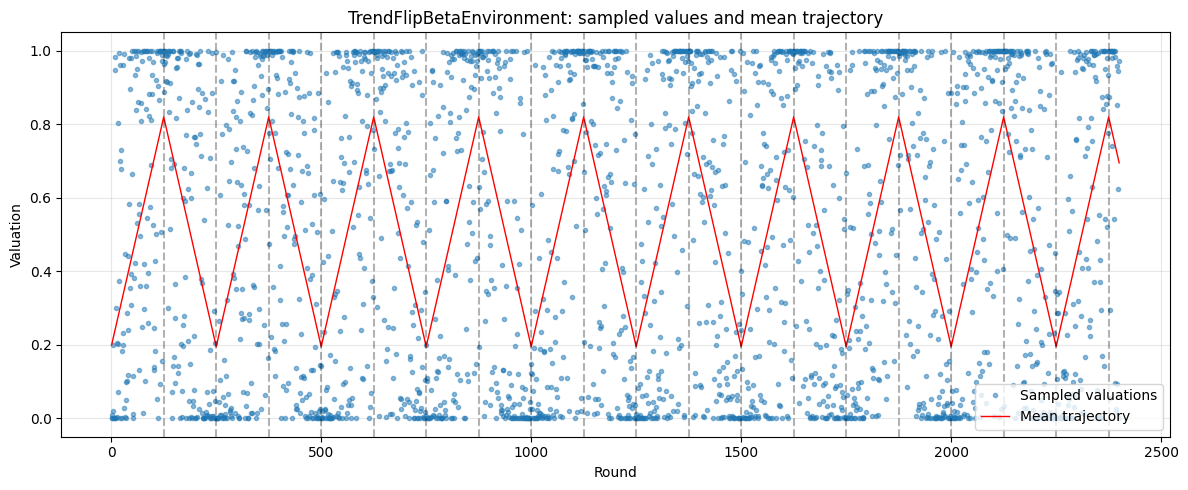

In [13]:
plot_trendflip_values(
    T=2400,
    u=0.005,
    K=125,
    mu0=0.2,
    v_target=0.15,
)

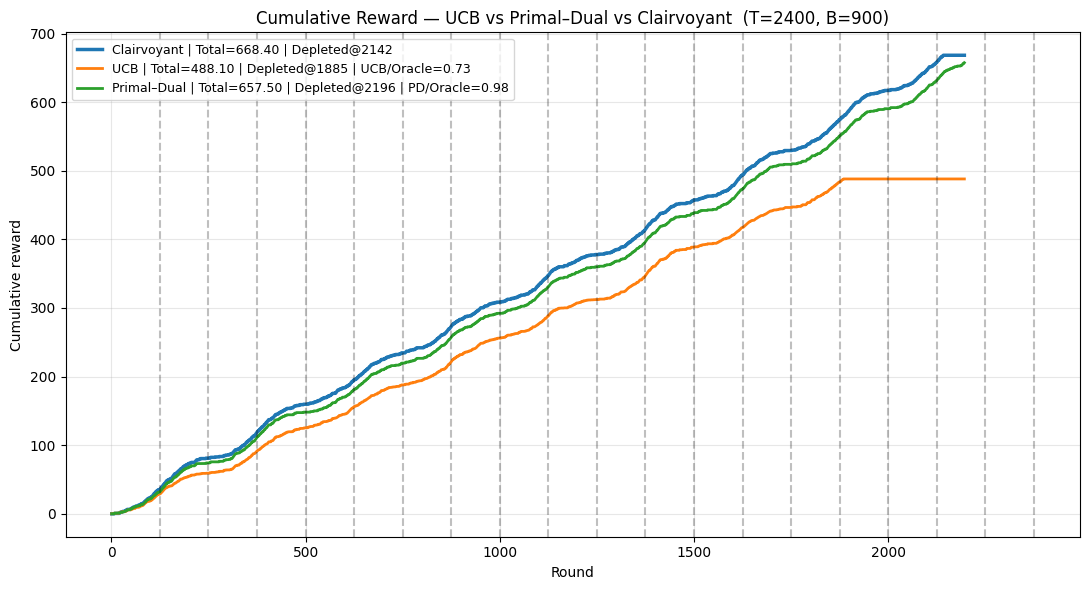

=== Final Results (TrendFlip env, with Oracle) ===
Clairvoyant | Total=668.40 | Depleted@2142
UCB | Total=488.10 | Depleted@1885 | UCB/Oracle=0.73
Primal–Dual | Total=657.50 | Depleted@2196 | PD/Oracle=0.98


In [14]:
res = run_agents_on_trendflip_env_with_oracle(
    arm_values=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    T=2400,
    B=900,         # B/T = 0.375
    u=0.005,       # mean drift per round
    K=125,         # flip every 125 rounds
    mu0=0.2,
    v_target=0.15,
    # PD params (tune as you like)
    exp3p_gamma=None,
    exp3p_eta=0.2,        # canonical eta (gamma/(3K))
    exp3p_dual_lr=0.01,    # pacing step = eta
    alpha=None
)